In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot


import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

## Make data

In [2]:
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

## Using graspologic ZG(2) method

In [3]:
from graspologic.embed import select_dimension
select_dimension(undirected_sbm)

([2, 4], [60.040654885507344, 11.571250884605346])

## Example use of using sklean minka estimation

In [65]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.

    # Postprocess the number of components required
    if n_components == 'mle':
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

In [66]:
minka(undirected_sbm)

3

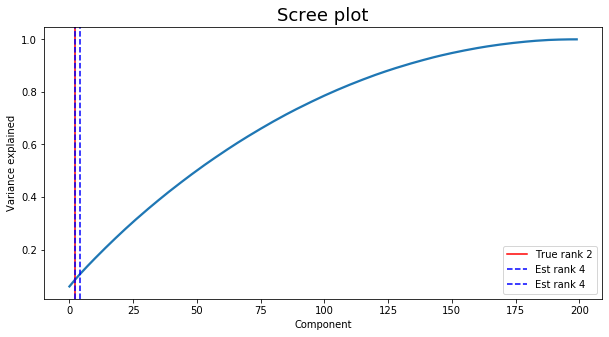

In [13]:
from graspologic.plot import screeplot
screeplot(X)
plt.axvline(2, label='True rank {}'.format(2), color='red')
plt.axvline(4, label='Est rank {}'.format(4), color='blue', ls='--')
plt.axvline(2, label='Est rank {}'.format(4), color='blue', ls='--')
plt.legend()

In [9]:
import scipy
k = int(np.ceil(np.log2(np.min(X.shape))))
D = scipy.sparse.linalg.svds(A=X, k=k, return_singular_vectors=False)
D = np.sort(D)[::-1]

In [14]:
D

array([98.90493025, 60.04065489, 12.11399685, 11.57125088, 11.23993611,
       10.94278271, 10.67831547, 10.43480617])

# Simulations

So I would like some input about my experiment design!

In [93]:
import random 
def make_linear_combos(U):
    vecs = np.zeros((U.shape[0], 15))
    lin_comb = 5
    for i in range(vecs.shape[1]):
        coefs = np.random.rand(lin_comb,1)
        inds = np.random.randint(0,U.shape[1], lin_comb)
        for j in range(lin_comb):
            vecs[:, i] += U[:, inds[j]] * coefs[j]
    return vecs
    

In [94]:
def make_corrupted_basis(size =20):    
    X_sim = np.random.normal(0, 1, (size, size))
    U, S, Vt = linalg.svd(X_sim)
    # this has rank 10 so we would expect that d chose to be 10 with superfluous parts on matrix
    uncorrupted_basis = U[:, :int(size/2)]
    v = make_linear_combos(U)
    corrupted_basis = np.hstack((uncorrupted_basis, v ))
    return corrupted_basis

In [99]:
# pertub matrix meaning that we have X + Delta where delta is random noise
# noise in this case will be normal 
def perturb(X, mu, std):
    perturb = np.random.normal(mu, std, (X.shape[0], X.shape[1]))
    return X + perturb

In [104]:
corrupted_basis = make_corrupted_basis()

In [129]:
select_dimension(corrupted_basis)[0]

[1, 3]

In [98]:
minka(corrupted_basis)

1

The experiment is as follows we start at 0 perturbation where both minka and ZG(2) should give us the same answer. Then we shall continue to perturb the matrix with larger and larger mu, std, and mu and std(maybe?). We shall graphically see which one changes with more perturbations

### std

In [150]:
stds = np.arange(0, 1.1, .1)
mus = np.arange(0, 11, 1)
corrupted_basis = make_corrupted_basis()
m_est = []
zg_est = []
for i in range(stds.shape[0]):
    perturbed = perturb(corrupted_basis, 0, stds[i])
    zg_est.append(select_dimension(perturbed)[0])
    m_est.append(minka(perturbed))

zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

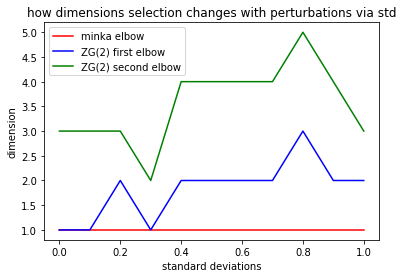

In [163]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via std")
ax.set(xlabel = "standard deviations", ylabel="dimension")
plt.show()


### mu

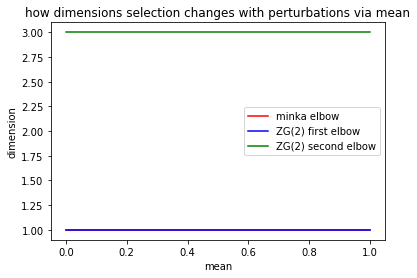

In [164]:
import matplotlib.pyplot as plt

m_est = []
zg_est = []
for i in range(mus.shape[0]):
    perturbed = perturb(corrupted_basis, mus[i], 0)
    zg_est.append(select_dimension(perturbed)[0])
    m_est.append(minka(perturbed))

zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)


fig, ax = plt.subplots()
ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()

### mu and std = 1

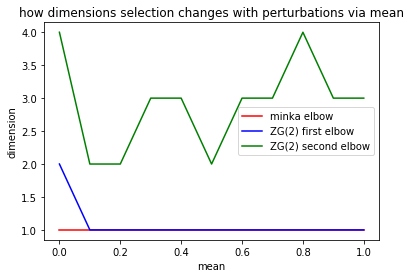

In [165]:
import matplotlib.pyplot as plt

m_est = []
zg_est = []
for i in range(mus.shape[0]):
    perturbed = perturb(corrupted_basis, mus[i], 1)
    zg_est.append(select_dimension(perturbed)[0])
    m_est.append(minka(perturbed))

zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)


fig, ax = plt.subplots()
ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()